In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

In [ ]:
! mkdir ~/.kaggle

In [ ]:
ls ~/.kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d karnikakapoor/art-portraits

100% 2.71G/2.72G [00:24<00:00, 192MB/s]
100% 2.72G/2.72G [00:24<00:00, 118MB/s]


In [ ]:
!unzip "/content/art-portraits.zip" -d "/content/dataset/"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/dataset/Portraits/Portraits/f6146667460dea42353f557b2d468084c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f62195767417687cca9055e66e7000c8c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f621ae78d576611ae1a1f281925408fcc.jpg  
  inflating: /content/dataset/Portraits/Portraits/f6252e5524b49052d4202d2351201a79c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f62dca883479a86802afc21287472ac9c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f62e4ee3e34405a0062fa329352c6331c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f632b8d8d4f29dd69c9c9e548e00b4e9c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f633658aad586dd475df0cdfd80577c9c.jpg  
  inflating: /content/dataset/Portraits/Portraits/f643c89e1f254c51591b7c92f2658d3ec.jpg  
  inflating: /content/dataset/Portraits/Portraits/f647bef85618ad016bb95efc2d44053cc.jpg  
  inflating: /content/dataset/Portraits/Portraits/f64

In [ ]:
data_path = "/content/dataset/Portraits/Portraits"
batch_s = 128
im_size = (64, 64, 3)
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (im_size[0], im_size[1]), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


In [ ]:
data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    data
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(batch_s,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


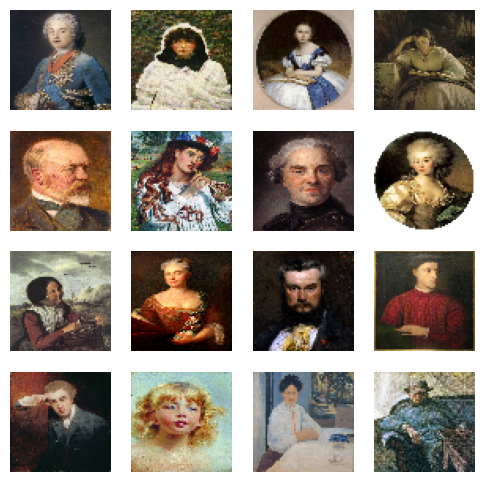

In [ ]:
plt.figure(figsize = (6,6))
k=0
n = 16
for i in range(n):
  ax = plt.subplot(4,4, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

In [ ]:
learning_rate = 2e-4
latent_dim = 100

In [ ]:
generator=tf.keras.Sequential([
  Input(shape=(latent_dim,)),
  Dense(4*4*latent_dim),
  Reshape((4,4,latent_dim)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         819712    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 256)       20

In [ ]:
discriminator=tf.keras.Sequential([
  Input(shape=(im_size[0],im_size[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')


],name='discriminator')

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,latent_dim))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,latent_dim))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [ ]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_di=100):
        self.latent_di = latent_di

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_di)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [ ]:
!mkdir generated

In [ ]:
EPOCHS=150
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(latent_dim)])

Epoch 1/150
32/32 [==============================] - 45s 603ms/step - d_loss: 1.2337 - g_loss: 0.8555
Epoch 2/150
32/32 [==============================] - 35s 607ms/step - d_loss: 1.2468 - g_loss: 0.8417
Epoch 3/150
32/32 [==============================] - 36s 630ms/step - d_loss: 1.2375 - g_loss: 0.8370
Epoch 4/150
32/32 [==============================] - 36s 617ms/step - d_loss: 1.2170 - g_loss: 0.8338
Epoch 5/150
32/32 [==============================] - 36s 614ms/step - d_loss: 1.2279 - g_loss: 0.8353
Epoch 6/150
32/32 [==============================] - 36s 607ms/step - d_loss: 1.2299 - g_loss: 0.8405
Epoch 7/150
32/32 [==============================] - 37s 644ms/step - d_loss: 1.2423 - g_loss: 0.8675
Epoch 8/150
32/32 [==============================] - 36s 615ms/step - d_loss: 1.2391 - g_loss: 0.8293
Epoch 9/150
32/32 [==============================] - 35s 605ms/step - d_loss: 1.2357 - g_loss: 0.8292
Epoch 10/150
32/32 [==============================] - 36s 613ms/step - d_loss: 1.2

<ipython-input-22-e4ab331f79ca>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,16))


32/32 [==============================] - 37s 605ms/step - d_loss: 1.2251 - g_loss: 0.8601
Epoch 22/150
32/32 [==============================] - 35s 609ms/step - d_loss: 1.2335 - g_loss: 0.8481
Epoch 23/150
32/32 [==============================] - 35s 607ms/step - d_loss: 1.2217 - g_loss: 0.8329
Epoch 24/150
32/32 [==============================] - 36s 596ms/step - d_loss: 1.2393 - g_loss: 0.8295
Epoch 25/150
32/32 [==============================] - 36s 628ms/step - d_loss: 1.2228 - g_loss: 0.8352
Epoch 26/150
32/32 [==============================] - 36s 618ms/step - d_loss: 1.2052 - g_loss: 0.8328
Epoch 27/150
32/32 [==============================] - 36s 614ms/step - d_loss: 1.2236 - g_loss: 0.8192
Epoch 28/150
32/32 [==============================] - 37s 632ms/step - d_loss: 1.2291 - g_loss: 0.8351
Epoch 29/150
32/32 [==============================] - 36s 602ms/step - d_loss: 1.2069 - g_loss: 0.8205
Epoch 30/150
32/32 [==============================] - 35s 613ms/step - d_loss: 1.2496 

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

In [ ]:
!zip -r folder_name.zip /content/generated

In [ ]:
from google.colab import files
files.download('folder_name.zip')